In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [2]:
df = pd.read_csv("data/customer_churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [5]:
# We change the type of column TotalCharges
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.TotalCharges = df.TotalCharges.fillna(0)

In [7]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [9]:
# We convert the type of the target variable to integer

df.churn = (df.churn == 'yes').astype(int)

In [10]:
df.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,7590-vhveg,female,0,yes,no,1,no,no_phone_service,dsl,no,...,no,no,no,no,month-to-month,yes,electronic_check,29.85,29.85,0
1,5575-gnvde,male,0,no,no,34,yes,no,dsl,yes,...,yes,no,no,no,one_year,no,mailed_check,56.95,1889.50,0
2,3668-qpybk,male,0,no,no,2,yes,no,dsl,yes,...,no,no,no,no,month-to-month,yes,mailed_check,53.85,108.15,1
3,7795-cfocw,male,0,no,no,45,no,no_phone_service,dsl,yes,...,yes,yes,no,no,one_year,no,bank_transfer_(automatic),42.30,1840.75,0
4,9237-hqitu,female,0,no,no,2,yes,no,fiber_optic,no,...,no,no,no,no,month-to-month,yes,electronic_check,70.70,151.65,1


In [12]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

y_train = df_train.churn.values
y_val = df_val.churn.values

del df_train['churn']
del df_val['churn']

## Exploratory data analysis

In [13]:
df_train_full.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [14]:
df_train_full.churn.value_counts()

0    4113
1    1521
Name: churn, dtype: int64

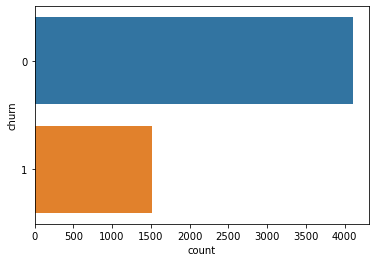

In [15]:
sns.countplot(y="churn", data=df_train_full);

We notice that this is an imbalanced dataset.

In [17]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
               'phoneservice', 'multiplelines', 'internetservice',
               'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
               'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
               'paymentmethod']


numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [18]:
df_train_full[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

## Feature importance analysis

In [28]:
print("Global churn: ", round(sum(df_train_full.churn)/df_train_full.shape[0], 4))

# We look at the gender variable
male_churn = df_train_full[df_train_full.gender == 'male'].churn.mean()
print("Male churn: ", round(male_churn, 4))

female_churn = df_train_full[df_train_full.gender == 'female'].churn.mean()
print("Female churn: ", round(female_churn, 4))


Global churn:  0.27
Male churn:  0.2632
Female churn:  0.2768


In [29]:
print("Global churn: ", round(sum(df_train_full.churn)/df_train_full.shape[0], 4))

# We look at the gender variable
partner_yes = df_train_full[df_train_full.partner == 'yes'].churn.mean()
print("Partner yes churn: ", round(partner_yes, 4))

partner_no = df_train_full[df_train_full.partner == 'no'].churn.mean()
print("Partner no churn: ", round(partner_no, 4))


Global churn:  0.27
Partner yes churn:  0.205
Partner no churn:  0.3298


In [31]:
# Let's compute mutual information
def calculate_mutual_information(series):
    return mutual_info_score(series, df_train_full.churn)

df_mi = df_train_full[categorical].apply(calculate_mutual_information)
df_mi = df_mi.sort_values(ascending=False).to_frame(name="MI")
df_mi

,MI
contract,0.098320
onlinesecurity,0.063085
techsupport,0.061032
internetservice,0.055868
onlinebackup,0.046923
deviceprotection,0.043453
paymentmethod,0.043210
streamingtv,0.031853
streamingmovies,0.031581
paperlessbilling,0.017589


<AxesSubplot:>

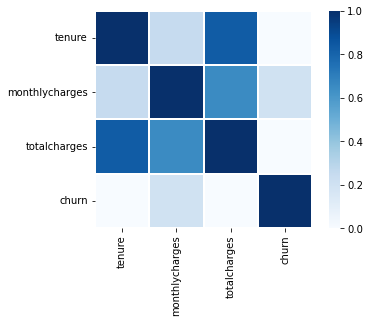

In [34]:
corr = df_train_full[numerical + ['churn']].corr()

sns.heatmap(corr, vmin=0, vmax=1, linewidths=2, square=True, cmap='Blues')

In [40]:
# We select the columns we'll use for training the model

categorical = ["contract", "onlinesecurity", "techsupport",
               "internetservice", "onlinebackup", "deviceprotection",
               "paymentmethod", "streamingtv", "streamingmovies",
               "paperlessbilling", "dependents"]

numerical = ["monthlycharges"]

In [41]:
cat_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical)
    ]
)

lr = LogisticRegression()

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('lr', lr)
    ]
)

pipeline.fit(df_train, y_train)

y_predict = pipeline.predict(df_val)